In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox

In [2]:
from utils.lof import LOF
from utils.metrics import nan_euclidean, elastic_nan_euclidean
from utils import get_table_players

In [3]:
from utils import Dataset

In [4]:
euclidean_regularized = elastic_nan_euclidean(1, 0, 0)

In [5]:
_4dm4_impute = Dataset('4dm4.db')

In [6]:
_4dm4_data = _4dm4_impute.select('scores', columns=['player_name', 'round', 'beatmap_type', 'beatmap_tag', 'score_logit'], where={
    'beatmap_type': ['LN', 'RC', 'HB'],
})

In [7]:
_4dm4_table = get_table_players(_4dm4_data)

In [8]:
standardized_4dm = pd.DataFrame(index=_4dm4_table.index)

In [9]:
for col in _4dm4_table.columns:
    mu = np.nanmean(_4dm4_table[col]); sigma = np.nanstd(_4dm4_table[col], ddof=1)
    standardized_4dm[col] = _4dm4_table[col].apply(lambda x: (x - mu) / sigma)

In [10]:
standardized_4dm.head()

,Q_RC_1,Q_RC_2,Q_LN_1,Q_HB_1,RO32_RC_1,RO32_RC_4,RO32_RC_5,RO32_LN_3,RO32_HB_1,RO16_RC_1,...,GF_RC_7,GF_LN_2,GF_LN_3,GF_LN_4,GF_HB_1,GF_HB_2,GF_HB_3,SF_RC_2,SF_HB_3,GF_RC_3
drag_,-1.271311,-0.888601,-0.288915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JPBenedictGame,-0.133422,0.052810,-0.519245,-0.407806,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iVALORUS,-2.538866,-1.609407,-2.138151,-1.485972,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL5,0.293309,-0.947536,0.162731,0.073857,-1.536132,-1.589838,-0.170574,-0.071868,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Tebo-,0.427527,-0.009594,0.551290,-0.779546,0.079211,1.000453,0.577630,0.090251,0.900541,0.542193,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
lof_euclid = LOF(5, euclidean_regularized)

In [12]:
lof_values = lof_euclid.fit_predict(standardized_4dm.values)

In [13]:
lof_4dm = pd.DataFrame(index=standardized_4dm.index)

lof_4dm['lof'] = lof_values

In [14]:
lof_4dm.loc['shokoha']

lof    3.555918
Name: shokoha, dtype: float64

In [15]:
lof_4dm.sort_values(by='lof', ascending=False).head(16)

,lof
dsdsdd,7.938778
Lazereed,6.597912
Ricizus,6.485866
samuelhklumpers,4.822352
MSKFA kemi,4.202919
HD_AdreNaline,4.015217
Keskidi,3.911713
Mr_adamello,3.586572
shokoha,3.555918
Enthalpy,3.545404


(array([89., 61., 31.,  8.,  6.,  2.,  0.,  0.,  2.,  1.]),
 array([0.42280728, 1.17440432, 1.92600136, 2.6775984 , 3.42919544,
        4.18079248, 4.93238952, 5.68398656, 6.4355836 , 7.18718064,
        7.93877768]),
 <BarContainer object of 10 artists>)

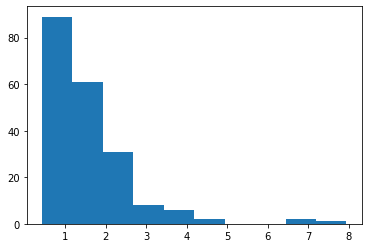

In [16]:
plt.hist(lof_4dm['lof'].values)

In [17]:
lof_4dm['lof'].quantile(0.25)

0.9988460129491807

In [18]:
lof_4dm['lof'].quantile(0.75)

1.9214571686556137

In [19]:
lof_4dm['lof'].quantile(0.95)

3.5039790143688365

In [20]:
lof_4dm['lof'].quantile(0.975)

4.0199092446233955